# IBM watsonx.governance Evaluation Studio - Tracking and Comparing AI Application Quality Evaluations

## Scenario Overview

Consider a development team building a RAG based chatbot—possibly using LLM Prompt or using an advanced agentic RAG chatbot—for their application. The underlying model powering the system is, say, **Gemma**, hosted on **Google Vertex AI**.

During the development phase, the team evaluates the chatbot by asking a set of questions. For each question:
- The relevant **context** is retrieved,
- A **response** is generated by the chatbot, and
- A **ground truth answer** (as it can be available during development) is used for comparison.

In addition to this **test data set**, the team has prepared a **validation set** of questions, which are also run against the application.

To assess the quality of the responses, the team uses the **IBM watsonx.governance SDK** to compute:
- RAG-specific metrics such as **faithfulness**, **context relevance**, and **answer relevance**
- **Readability metrics** of the generated responses

Both the development and validation sets have corresponding computed metrics.

To **track these evaluations**, the team uses **Evaluation Studio** in **watsonx.governance**:
- An **AI Experiment** is created.
- Both evaluation runs (development and validation) are logged under this experiment.
- The experiment runs are then compared using **AI Evaluation**.
- Finally, the results and comparisons are **visualized through the Evaluation Studio UI** for further insights.

This notebook walks through this end-to-end workflow.

PLEASE NOTE: THE EVALUATION METHOD DESCRIBED IN THIS NOTEBOOK FOR EXTERNAL PROMPTS DOES NOT MAKE USE OF THE DETACHED PTA ROUTE


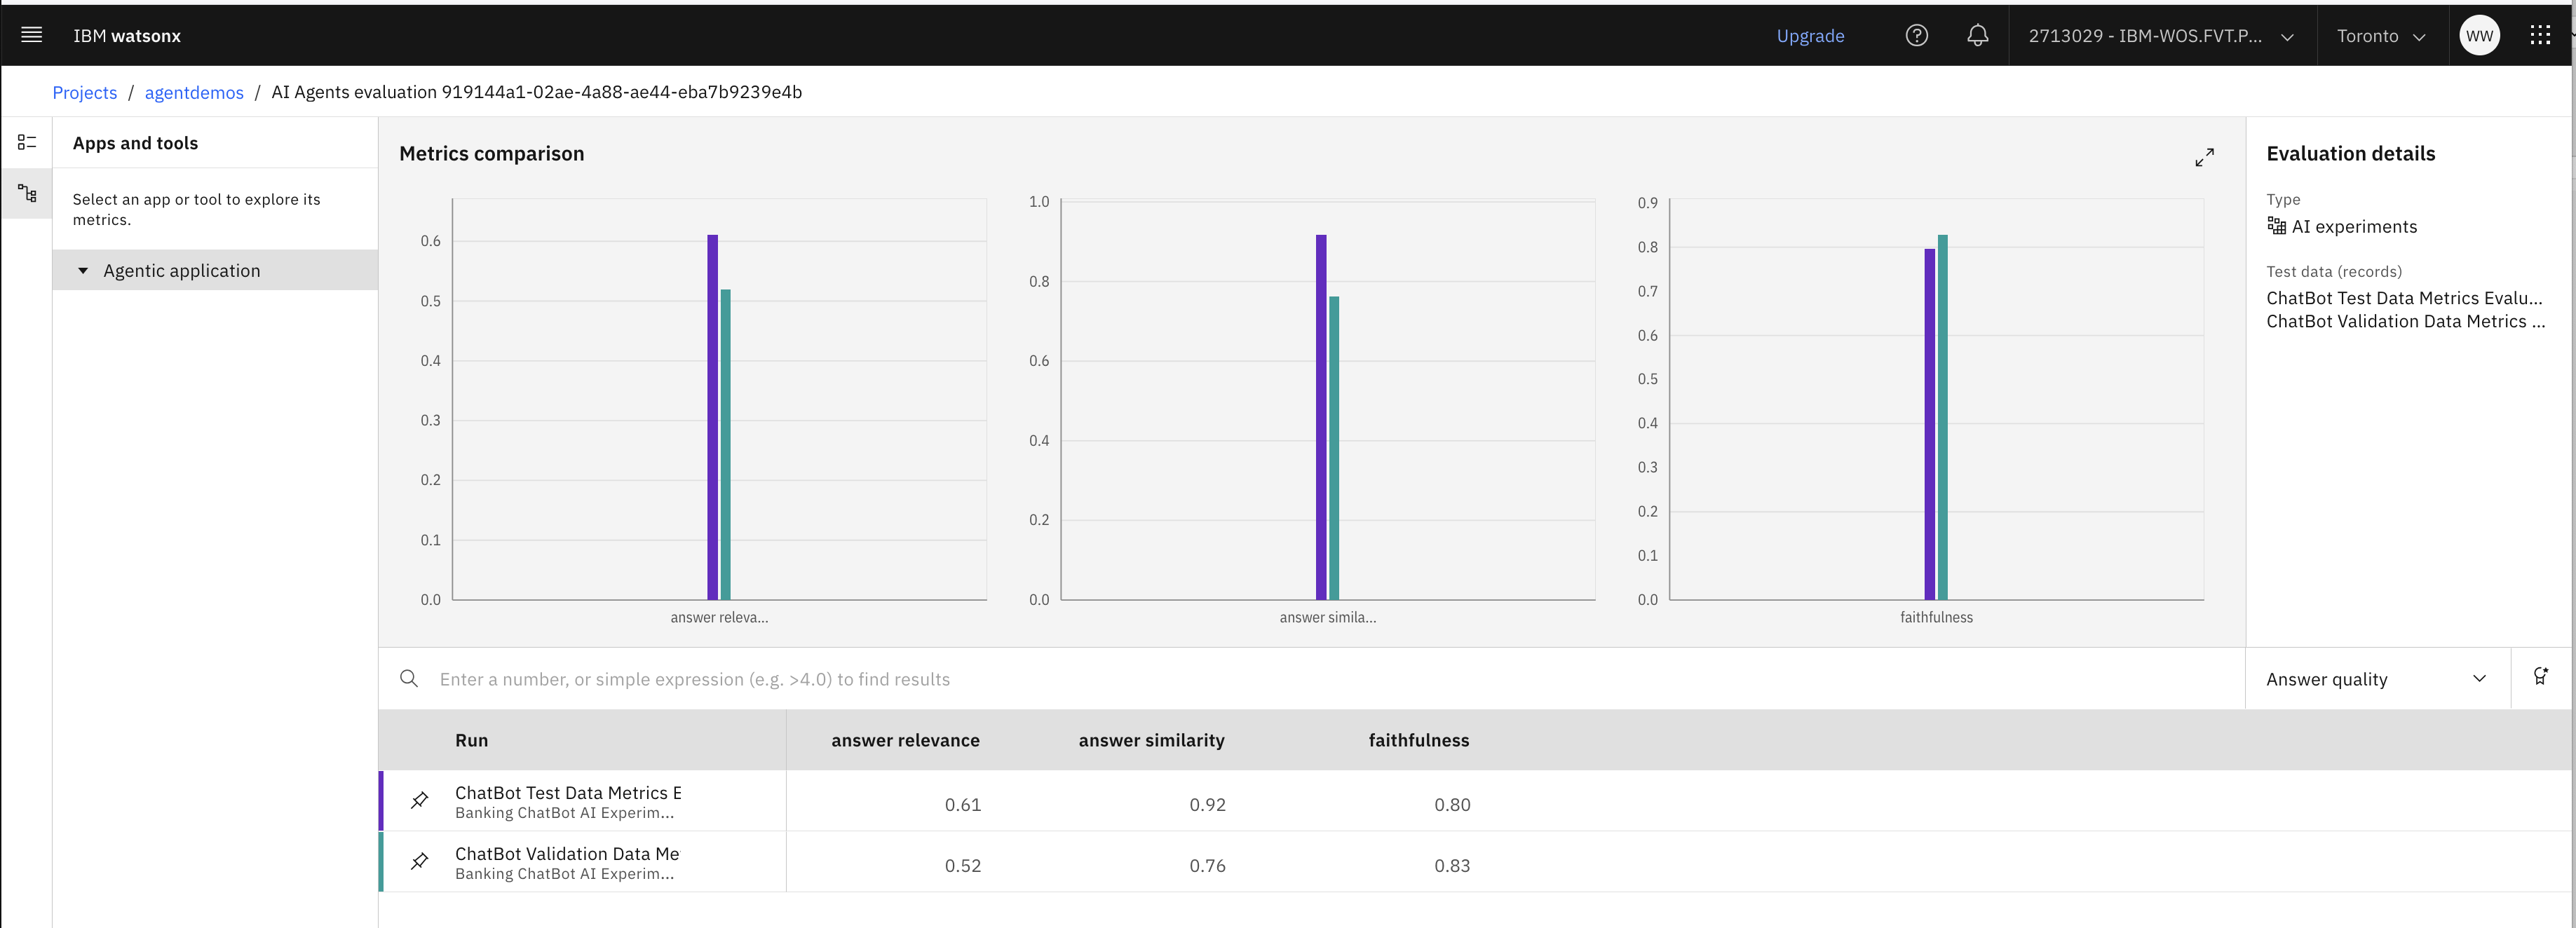

#### Required pip installations - needs cleaning

In [ ]:
!pip install --quiet traceloop-sdk==0.40.6 langtrace-python-sdk==3.3.4 trace-attributes==7.1.0 pydantic==2.10.6 opentelemetry-exporter-otlp-proto-http==1.34.1 datasets==3.6.0 | tail -n 1
!pip install --quiet "ibm-watsonx-gov[agentic,visualization,tools]" langchain-chroma langchain-openai pypdf | tail -n 1

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Credentials to run watsonx.gov SDK and AI Experiments

In [ ]:
WATSONX_APIKEY = "[Your IBM IAM API Key]"
IAM_URL = "https://iam.cloud.ibm.com"
PLATFORM_URL = "https://api.ca-tor.dai.cloud.ibm.com"
WXG_URL = "https://ca-tor.api.aiopenscale.cloud.ibm.com"
WATSONX_PROJECT_ID = "[Your IBM watsonx Project ID]"
WXG_INSTANCE_ID = '[Your IBM watsonx.governance instance ID]'

### Initialize the watsonx.gov API client object


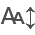

In [3]:
from ibm_watsonx_gov.ai_experiments.ai_experiments_client import AIExperimentsClient
from ibm_watsonx_gov.entities.ai_experiment import AIExperimentRun, AIExperiment
from ibm_watsonx_gov.clients.api_client import APIClient
from ibm_watsonx_gov.entities.credentials import Credentials
credentials = Credentials(api_key=WATSONX_APIKEY,
                          url=WXG_URL,
                          service_instance_id=WXG_INSTANCE_ID)

# Initializing APIClient
api_client = APIClient(credentials=credentials)

In [4]:
import pandas as pd
import numpy as np

**Note:** This notebook does not cover running the application or executing prompts against the underlying model. It assumes that the development team has already processed the questions using the LLM prompt or the agentic application and has obtained the corresponding contexts, generated answers, and ground truth answers.

### Test data 

In [5]:
!rm -fr banking_rag_chatbot_qna_1.csv
!wget "https://raw.githubusercontent.com/ravichamarthy/watsonx-explorations/refs/heads/main/banking_rag_chatbot_qna_1.csv"

--2025-08-06 05:44:51--  https://raw.githubusercontent.com/ravichamarthy/watsonx-explorations/refs/heads/main/banking_rag_chatbot_qna_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3995 (3.9K) [text/plain]
Saving to: ‘banking_rag_chatbot_qna_1.csv’

banking_rag_chatbot 100%[===================>]   3.90K  --.-KB/s    in 0.001s  

2025-08-06 05:44:52 (3.50 MB/s) - ‘banking_rag_chatbot_qna_1.csv’ saved [3995/3995]



In [6]:
banking_rag_chatbot_qna_1 = pd.read_csv("banking_rag_chatbot_qna_1.csv")
banking_rag_chatbot_qna_1.head()

question  \
0  What is the minimum balance required for a sav...   
1                 Can I open a fixed deposit online?   
2                How can I block my lost debit card?   
3       What is the interest rate on personal loans?   
4                  Are NRIs eligible for home loans?   

                                             context  \
0  The minimum average monthly balance (AMB) requ...   
1  Yes, customers with access to internet banking...   
2  If your debit card is lost or stolen, it is cr...   
3  The bank offers personal loans at interest rat...   
4  Non-Resident Indians (NRIs) are eligible to ap...   

                                              answer  \
0  The minimum balance required is 10000 for urba...   
1  Yes, you can open a fixed deposit online via i...   
2  You should block your lost debit card immediat...   
3  Personal loan interest rates range between 10....   
4  Yes, NRIs can get home loans in India for up t...   

                                        grouth_truth  
0  Depending on the branch location, the required...  
1  Yes, fixed deposits can be opened online via i...  
2  Immediately block your lost debit card using m...  
3  Interest rates for personal loans range from 1...  
4  NRIs can apply for home loans up to 20 years t...

### Validation data

In [7]:
!rm -fr banking_rag_chatbot_qna_2.csv
!wget "https://raw.githubusercontent.com/ravichamarthy/watsonx-explorations/refs/heads/main/banking_rag_chatbot_qna_2.csv"

--2025-08-06 05:44:56--  https://raw.githubusercontent.com/ravichamarthy/watsonx-explorations/refs/heads/main/banking_rag_chatbot_qna_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3308 (3.2K) [text/plain]
Saving to: ‘banking_rag_chatbot_qna_2.csv’

banking_rag_chatbot 100%[===================>]   3.23K  --.-KB/s    in 0.001s  

2025-08-06 05:44:56 (5.76 MB/s) - ‘banking_rag_chatbot_qna_2.csv’ saved [3308/3308]



In [8]:
banking_rag_chatbot_qna_2 = pd.read_csv("banking_rag_chatbot_qna_2.csv")
banking_rag_chatbot_qna_2.head()

question  \
0         How can I apply for a credit card online?   
1          What are the features of mobile banking?   
2                   How do I close my bank account?   
3  Can I link multiple bank accounts to one UPI ID?   
4            What happens if I miss an EMI payment?   

                                             context  \
0  To apply for a credit card online, customers c...   
1  The mobile banking app offers a wide range of ...   
2  To close your bank account, visit the nearest ...   
3  Yes, UPI apps allow users to link multiple ban...   
4  Missing an EMI (Equated Monthly Installment) p...   

                                              answer  \
0  You can apply for a credit card online by subm...   
1  Mobile banking offers fund transfers, bill pay...   
2  To close your account, visit the branch with a...   
3  Yes, you can link multiple accounts to one UPI...   
4  If you miss an EMI, it can affect your credit ...   

                                        grouth_truth  
0  Visit the bank’s website or app, choose a card...  
1  Mobile banking supports transfers, bill paymen...  
2  You must visit the branch with ID proof and su...  
3  Yes, UPI apps support linking multiple account...  
4  Missing an EMI leads to penalties, interest, a...

# IBM watsonx.gov SDK evaluations starts

### Configurations

- Define the `GenAIConfiguration`, specifying which fields represent the **question**, **context**, the **response**, and the **grount truth**
- Configure the use of **RAG evaluation metrics**, which require the **input question**, **retrieved context**, **generated response**, and the **ground truth answer**.
- *(Note: Only a subset of available metrics is shown here. For the complete list, refer to the [watsonx.governance documentation](https://ibm.github.io/ibm-watsonx-gov/index.html).)*


In [9]:
from ibm_watsonx_gov.config import GenAIConfiguration
from ibm_watsonx_gov.metrics import AnswerRelevanceMetric
from ibm_watsonx_gov.metrics import AnswerSimilarityMetric
from ibm_watsonx_gov.metrics import FaithfulnessMetric
from ibm_watsonx_gov.metrics import ContextRelevanceMetric
from ibm_watsonx_gov.metrics import TextGradeLevelMetric
from ibm_watsonx_gov.metrics import TextReadingEaseMetric
from ibm_watsonx_gov.entities.enums import TaskType, MetricGroup

config = GenAIConfiguration(
    input_fields=["question"],
    context_fields=["context"],
    output_fields=["answer"],
    reference_fields=["grouth_truth"]
)

metrics = [
    AnswerRelevanceMetric(),
    AnswerSimilarityMetric(),
    FaithfulnessMetric(),
    ContextRelevanceMetric(),
    TextGradeLevelMetric(),
    TextReadingEaseMetric(),
]

### Evaluate the Metrics
- Create MetricsEvaluator
- Evaluate the metrics against the data produced from the underlying prompt or Agent

In [10]:
from ibm_watsonx_gov.clients.api_client import APIClient
from ibm_watsonx_gov.evaluators import MetricsEvaluator

evaluator = MetricsEvaluator(
    api_client=APIClient(credentials=credentials),
    configuration=config,
)

## Evaluate on Test Data

In [11]:
evaluation_results_1 = evaluator.evaluate(
    data=banking_rag_chatbot_qna_1,
    metrics=metrics
)
evaluation_results_df_1 = evaluation_results_1.to_df()
evaluation_results_df_1

answer_relevance.token_recall  answer_similarity.sentence_bert_mini_lm  \
0                       0.625000                                 0.885743   
1                       0.833333                                 0.865436   
2                       0.500000                                 0.968154   
3                       0.428571                                 0.948112   
4                       0.666667                                 0.918458   

   faithfulness.sentence_bert_mini_lm  \
0                            0.618365   
1                            0.749987   
2                            0.927092   
3                            0.793382   
4                            0.890104   

   context_relevance.sentence_bert_mini_lm  \
0                                 0.647263   
1                                 0.714722   
2                                 0.861759   
3                                 0.783285   
4                                 0.807130   

   text_grade_level.flesch_kincaid_grade  \
0                               8.637000   
1                              10.525000   
2                              10.475294   
3                               6.132632   
4                              10.486667   

   text_reading_ease.flesch_reading_ease  
0                              55.403500  
1                              41.867500  
2                              50.238824  
3                              62.375088  
4                              62.625000

## Evaluate on Validation Data

In [12]:
evaluation_results_2 = evaluator.evaluate(
    data=banking_rag_chatbot_qna_2,
    metrics=metrics
)
evaluation_results_df_2 = evaluation_results_2.to_df()
evaluation_results_df_2

answer_relevance.token_recall  answer_similarity.sentence_bert_mini_lm  \
0                       0.750000                                 0.414588   
1                       0.333333                                 0.836818   
2                       0.285714                                 0.810797   
3                       0.800000                                 0.864264   
4                       0.428571                                 0.886635   

   faithfulness.sentence_bert_mini_lm  \
0                            0.808024   
1                            0.769754   
2                            0.849130   
3                            0.872116   
4                            0.841189   

   context_relevance.sentence_bert_mini_lm  \
0                                 0.738061   
1                                 0.707740   
2                                 0.832150   
3                                 0.880836   
4                                 0.804335   

   text_grade_level.flesch_kincaid_grade  \
0                              10.019048   
1                               8.897778   
2                               7.818889   
3                               5.852222   
4                               6.725263   

   text_reading_ease.flesch_reading_ease  
0                              60.634286  
1                              47.300000  
2                              71.065000  
3                              85.165000  
4                              80.686842

## Utility method to average the individual record level metrics, and construct the Experiment Run object

In [13]:
def construct_run_metrics(df):
    import pandas as pd
    
    # Define column mapping and grouping
    metric_mapping = {
        'answer_relevance.token_recall': ('answer_relevance', 'answer_quality'),
        'answer_similarity.sentence_bert_mini_lm': ('answer_similarity', 'answer_quality'),
        'faithfulness.sentence_bert_mini_lm': ('faithfulness', 'answer_quality'),
        'context_relevance.sentence_bert_mini_lm': ('context_relevance', 'retrieval_quality'),
        'text_grade_level.flesch_kincaid_grade': ('text_grade_level', 'readability'),
        'text_reading_ease.flesch_reading_ease': ('text_reading_ease', 'readability')
    }
    
    # Aggregate and build JSON list
    run_metric_results = []
    for col, (new_name, group) in metric_mapping.items():
        if col in df.columns:
            avg_value = df[col].mean()
            count = df[col].count()
            run_metric_results.append({
                "name": new_name,
                "value": round(avg_value, 4),
                "group": group,
                "count": int(count)
            })

    return run_metric_results

## Test Data Run metrics

In [14]:
run_1_metric_results = construct_run_metrics(evaluation_results_df_1)
# Preview result
import json
print(json.dumps(run_1_metric_results, indent=2))

[
  {
    "name": "answer_relevance",
    "value": 0.6107,
    "group": "answer_quality",
    "count": 5
  },
  {
    "name": "answer_similarity",
    "value": 0.9172,
    "group": "answer_quality",
    "count": 5
  },
  {
    "name": "faithfulness",
    "value": 0.7958,
    "group": "answer_quality",
    "count": 5
  },
  {
    "name": "context_relevance",
    "value": 0.7628,
    "group": "retrieval_quality",
    "count": 5
  },
  {
    "name": "text_grade_level",
    "value": 9.2513,
    "group": "readability",
    "count": 5
  },
  {
    "name": "text_reading_ease",
    "value": 54.502,
    "group": "readability",
    "count": 5
  }
]


## Validation Data Run Metrics

In [15]:
run_2_metric_results = construct_run_metrics(evaluation_results_df_2)
# Preview result
import json
print(json.dumps(run_2_metric_results, indent=2))

[
  {
    "name": "answer_relevance",
    "value": 0.5195,
    "group": "answer_quality",
    "count": 5
  },
  {
    "name": "answer_similarity",
    "value": 0.7626,
    "group": "answer_quality",
    "count": 5
  },
  {
    "name": "faithfulness",
    "value": 0.828,
    "group": "answer_quality",
    "count": 5
  },
  {
    "name": "context_relevance",
    "value": 0.7926,
    "group": "retrieval_quality",
    "count": 5
  },
  {
    "name": "text_grade_level",
    "value": 7.8626,
    "group": "readability",
    "count": 5
  },
  {
    "name": "text_reading_ease",
    "value": 68.9702,
    "group": "readability",
    "count": 5
  }
]


# Creating AI Experiment asset to capture Metrics Evaluation Runs

In [16]:
# Creating AI Experiment asset
name = "Banking ChatBot AI Experiment"
description = "Evaluation of a RAG-based chatbot for common banking queries, using manually curated test cases across account services, loans, cards, digital banking, and UPI. Each case includes the user question, retrieved context, model answer, and human-verified ground truth for quality benchmarking."

ai_experiment_client = AIExperimentsClient(api_client=api_client, project_id=WATSONX_PROJECT_ID)
ai_experiment = AIExperiment(name=name, 
                             description=description,
                             component_type="prompt",
                             component_name="Test prompt")

ai_experiment_asset = ai_experiment_client.create(ai_experiment)
ai_experiment_id = ai_experiment_asset.asset_id

Created AI experiment asset with id 843bb77a-2a6b-4509-88ab-5bb560dea213.



In [17]:
ai_experiment_asset.to_json()

{'container_id': '1391cc48-412a-4e80-8bff-b0737b1fefb7',
 'container_type': 'project',
 'container_name': '',
 'name': 'Banking ChatBot AI Experiment',
 'description': 'Evaluation of a RAG-based chatbot for common banking queries, using manually curated test cases across account services, loans, cards, digital banking, and UPI. Each case includes the user question, retrieved context, model answer, and human-verified ground truth for quality benchmarking.',
 'asset_type': 'ai_experiment',
 'created_at': '2025-08-06T12:46:18Z',
 'owner_id': 'IBMid-550002SR1C',
 'asset_id': '843bb77a-2a6b-4509-88ab-5bb560dea213',
 'creator_id': 'IBMid-550002SR1C',
 'component_id': '',
 'component_type': 'prompt',
 'component_name': 'Test prompt',
 'runs': []}

## Create the Experiment Run for the Test Data

In [18]:
import uuid
experiment_run_1_details = AIExperimentRun(
                            run_id=str(uuid.uuid4()),
                            run_name="ChatBot Test Data Metrics Evaluation",
                            nodes=[],
                            duration=10
                        )
experiment_run_1_details

AIExperimentRun(run_id='014f3233-805f-47f7-96de-84f17c6ada45', run_name='ChatBot Test Data Metrics Evaluation', created_at='', created_by='', test_data={}, tracked=False, id_deleted=False, attachment_id='', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={})

## Create the Experiment Run for the Validation Data

In [19]:
import uuid
experiment_run_2_details = AIExperimentRun(
                            run_id=str(uuid.uuid4()),
                            run_name="ChatBot Validation Data Metrics Evaluation",
                            nodes=[],
                            duration=10
                        )
experiment_run_2_details

AIExperimentRun(run_id='b4768323-0f6f-4939-914b-15ba70c641b0', run_name='ChatBot Validation Data Metrics Evaluation', created_at='', created_by='', test_data={}, tracked=False, id_deleted=False, attachment_id='', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={})

## Associate the Test Data Run metrics with the experiment

In [20]:
ai_experiment_client.update(
    ai_experiment_id=ai_experiment_id,
    experiment_run_details=experiment_run_1_details,
    evaluation_results=run_1_metric_results
)


Storing evaluation result for experiment run 014f3233-805f-47f7-96de-84f17c6ada45 of AI experiment 843bb77a-2a6b-4509-88ab-5bb560dea213.

Creating attachment for asset 843bb77a-2a6b-4509-88ab-5bb560dea213.

Successfully created attachment d9ea0180-bd4b-4fb5-8363-b61c713ef1bb for asset 843bb77a-2a6b-4509-88ab-5bb560dea213. Time taken: 2.1297202110290527.

Updated experiment run details for run ChatBot Test Data Metrics Evaluation of AI experiment 843bb77a-2a6b-4509-88ab-5bb560dea213.

Updated AI experiment asset 843bb77a-2a6b-4509-88ab-5bb560dea213.



AIExperiment(container_id='', container_type='', container_name='', name='AI Experiment for Agent', description='', asset_type='', created_at='', owner_id='', asset_id='', creator_id='', component_id='', component_type='prompt', component_name='Test prompt', runs=[AIExperimentRun(run_id='014f3233-805f-47f7-96de-84f17c6ada45', run_name='ChatBot Test Data Metrics Evaluation', created_at='2025-08-06T12:46:30Z', created_by='IBMid-550002SR1C', test_data={'total_rows': 5}, tracked=False, id_deleted=False, attachment_id='d9ea0180-bd4b-4fb5-8363-b61c713ef1bb', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={})])

## Associate the Validation Data Run metrics with the experiment

In [21]:
ai_experiment_client.update(
    ai_experiment_id=ai_experiment_id,
    experiment_run_details=experiment_run_2_details,
    evaluation_results=run_2_metric_results
)


Storing evaluation result for experiment run b4768323-0f6f-4939-914b-15ba70c641b0 of AI experiment 843bb77a-2a6b-4509-88ab-5bb560dea213.

Creating attachment for asset 843bb77a-2a6b-4509-88ab-5bb560dea213.

Successfully created attachment 26d353fa-32b2-42bc-a8d6-af54c7906de1 for asset 843bb77a-2a6b-4509-88ab-5bb560dea213. Time taken: 1.455859899520874.

Updated experiment run details for run ChatBot Validation Data Metrics Evaluation of AI experiment 843bb77a-2a6b-4509-88ab-5bb560dea213.

Updated AI experiment asset 843bb77a-2a6b-4509-88ab-5bb560dea213.



AIExperiment(container_id='', container_type='', container_name='', name='AI Experiment for Agent', description='', asset_type='', created_at='', owner_id='', asset_id='', creator_id='', component_id='', component_type='prompt', component_name='Test prompt', runs=[AIExperimentRun(run_id='014f3233-805f-47f7-96de-84f17c6ada45', run_name='ChatBot Test Data Metrics Evaluation', created_at='2025-08-06T12:46:30Z', created_by='IBMid-550002SR1C', test_data={'total_rows': 5}, tracked=False, id_deleted=False, attachment_id='d9ea0180-bd4b-4fb5-8363-b61c713ef1bb', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={}), AIExperimentRun(run_id='b4768323-0f6f-4939-914b-15ba70c641b0', run_name='ChatBot Validation Data Metrics Evaluation', created_at='2025-08-06T12:46:33Z', created_by='IBMid-550002SR1C', test_data={'total_rows': 5}, tracked=False, id_deleted=False, attachment_id='26d353fa-32b2-42bc-a8d6-af54c7906de1', nodes=[], description='', source_name='

### Check whether the runs are associated or not.

In [22]:
ai_experiment = ai_experiment_client.get(ai_experiment_id)
ai_experiment.to_json()

Retrieved AI experiment asset 843bb77a-2a6b-4509-88ab-5bb560dea213.



{'container_id': '1391cc48-412a-4e80-8bff-b0737b1fefb7',
 'container_type': 'project_id',
 'container_name': 'agentdemos',
 'name': 'Banking ChatBot AI Experiment',
 'description': 'Evaluation of a RAG-based chatbot for common banking queries, using manually curated test cases across account services, loans, cards, digital banking, and UPI. Each case includes the user question, retrieved context, model answer, and human-verified ground truth for quality benchmarking.',
 'asset_type': 'ai_experiment',
 'created_at': '2025-08-06T12:46:18Z',
 'owner_id': 'IBMid-550002SR1C',
 'asset_id': '843bb77a-2a6b-4509-88ab-5bb560dea213',
 'creator_id': 'IBMid-550002SR1C',
 'component_id': '',
 'component_type': 'prompt',
 'component_name': 'Test prompt',
 'runs': [{'run_id': '014f3233-805f-47f7-96de-84f17c6ada45',
   'run_name': 'ChatBot Test Data Metrics Evaluation',
   'created_at': '2025-08-06T12:46:30Z',
   'created_by': 'IBMid-550002SR1C',
   'test_data': {'total_rows': 5},
   'tracked': False,


## Create the AI Evaluation Asset with the experiment that would create the watsonx.governance AI Evaluation Studio asset

In [23]:
ai_evaluation = ai_experiment_client.create_ai_evaluation_asset([ai_experiment_id])

Retrieved AI experiment asset 843bb77a-2a6b-4509-88ab-5bb560dea213.

Created AI Evaluation asset with id 364c0596-1503-4bda-b712-ff2b83fe1348.


In [24]:
ai_evaluation.to_json()

{'container_id': '1391cc48-412a-4e80-8bff-b0737b1fefb7',
 'container_type': 'project',
 'container_name': 'AI Agents evaluation 919144a1-02ae-4a88-ae44-eba7b9239e4b',
 'name': 'AI Agents evaluation 919144a1-02ae-4a88-ae44-eba7b9239e4b',
 'description': 'AI Agents evaluation',
 'asset_type': 'ai_evaluation',
 'created_at': '2025-08-06T12:46:40Z',
 'owner_id': 'IBMid-550002SR1C',
 'asset_id': '364c0596-1503-4bda-b712-ff2b83fe1348',
 'creator_id': 'IBMid-550002SR1C',
 'asset_details': {'task_ids': [],
  'operational_space_id': 'development',
  'input_data_type': 'unstructured_text',
  'evaluation_asset_type': 'ai_experiment'},
 'evaluation_configuration': {'monitors': {'agentic_ai_quality': {'parameters': {'metrics_configuration': {}}}},
  'evaluation_assets': [{'id': '843bb77a-2a6b-4509-88ab-5bb560dea213',
    'container_id': '1391cc48-412a-4e80-8bff-b0737b1fefb7',
    'container_type': 'project',
    'name': 'Banking ChatBot AI Experiment',
    'run_id': '014f3233-805f-47f7-96de-84f17c6

Use the above href link to navigate to the Evaluation Studio for this Experiment Run.

Author: ravi.chamarthy@in.ibm.com